# Comparisons with BGEP ULS sea ice draft estimates updated with new data

**Summary:** In this notebook, we produce comparisons of winter monthly gridded ICESat-2 and CryoSat-2 sea ice thickness data with draft measurements obtained from Upward Looking Sonar moorings deployed in the Beaufort Sea. 

**Version history**: Version 1 (05/01/2025)
 

# Import notebook dependencies

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
import itertools
import pyproj 
from netCDF4 import Dataset
import scipy.interpolate 
from utils.read_data_utils import read_book_data, read_IS2SITMOGR4 # Helper function for reading the data from the bucket
from utils.plotting_utils import compute_gridcell_winter_means, interactiveArcticMaps, interactive_winter_mean_maps, interactive_winter_comparison_lineplot # Plotting
from scipy import stats
import datetime
# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 


In [2]:
# Set some plotting parameters
mpl.rcParams.update({
    "text.usetex": False,  # Use LaTeX for rendering
    "font.family": "sans-serif",
    "lines.linewidth": 1.,
    "font.size": 8,
    #"lines.alpha": 0.8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8
})
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['figure.dpi'] = 300 

In [3]:
int_str = '_int'

start_date = "Nov 2018"
end_date = "Apr 2021"
options = {
    'IS-2/NSIM': {'thickness': 'ice_thickness'+int_str, 'snow_depth': 'snow_depth'+int_str},
    'IS-2/SM-LG': {'thickness': 'ice_thickness_sm'+int_str, 'snow_depth': 'snow_depth_sm'+int_str},
    'IS-2/MW99': {'thickness': 'ice_thickness_mw99'+int_str, 'snow_depth': 'snow_depth_mw99'+int_str},
    'IS-2/NSIM/J22': {'thickness': 'ice_thickness_j22'+int_str, 'snow_depth': 'snow_depth'+int_str},
    'CS-2/SM-LG': {'thickness': 'ice_thickness_cs2_ubris', 'snow_depth': 'snow_depth_sm'+int_str},
}

# DO A FULL RUN UP TO 2023

#start_date = "Nov 2018"
#end_date = "Apr 2023"
#options = {
#    'nsim': {'thickness': 'ice_thickness', 'snow_depth': 'snow_depth'},
#    'nsim_int': {'thickness': 'ice_thickness_int', 'snow_depth': 'snow_depth_int'},
#    'mw99': {'thickness': 'ice_thickness_mw99', 'snow_depth': 'snow_depth_mw99'},
#    'j22': {'thickness': 'ice_thickness_j22', 'snow_depth': 'snow_depth'}}




In [4]:
# Load the all-season wrangled dataset
IS2SITMOGR4_v3 = xr.open_dataset('./data/book_data_allseason.nc')
print("Successfully loaded all-season wrangled dataset")

Successfully loaded all-season wrangled dataset


In [5]:

# Get some map proj info needed for later functions
out_proj = 'EPSG:3411'
mapProj = pyproj.Proj("+init=" + out_proj)

xIS2 = IS2SITMOGR4_v3.x.values
yIS2 = IS2SITMOGR4_v3.y.values
xptsIS2, yptsIS2 = np.meshgrid(xIS2, yIS2)

out_lons = IS2SITMOGR4_v3.longitude.values
out_lats = IS2SITMOGR4_v3.latitude.values

# Set Inner Arctic domain
innerArctic = [1,2,3,4,5,6]

In [6]:
IS2SITMOGR4_v3

<xarray.Dataset>
Dimensions:                         (time: 33, y: 448, x: 304)
Coordinates:
  * time                            (time) datetime64[ns] 2018-11-15 ... 2021...
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
Data variables: (12/47)
    crs                             (time) float64 ...
    ice_thickness_sm                (time, y, x) float32 ...
    ice_thickness_unc               (time, y, x) float32 ...
    num_segments                    (time, y, x) float32 ...
    mean_day_of_month               (time, y, x) float32 ...
    snow_depth_sm                   (time, y, x) float32 ...
    ...                              ...
    ice_density_j22_int             (time, y, x) float32 ...
    ice_thickness_j22_int           (time, y, x) float32 ...
    ice_thickness_cs2_ubris         (time, y, x) float64 ...
    cs2_sea_ice_type_UBRIS          (time, y, x) float64 ...
    cs2_sea_ice_density_UBRIS       (time, y, x) float64 ...
    cs2is2_snow_depth               (time, y, x) float64 ...
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V0 dataset.
    history:      Created 20/12/23

In [7]:
# Define the cutoff date
#cutoff_date = pd.Timestamp('2021-08-15')

# Filter the data to include only dates up to the cutoff date to be consistent with SM
#IS2SITMOGR4_v3 = IS2SITMOGR4_v3.where(IS2SITMOGR4_v3['time'] >= cutoff_date, drop=True)



In [8]:
options.items()

dict_items([('IS-2/NSIM', {'thickness': 'ice_thickness_int', 'snow_depth': 'snow_depth_int'}), ('IS-2/SM-LG', {'thickness': 'ice_thickness_sm_int', 'snow_depth': 'snow_depth_sm_int'}), ('IS-2/MW99', {'thickness': 'ice_thickness_mw99_int', 'snow_depth': 'snow_depth_mw99_int'}), ('IS-2/NSIM/J22', {'thickness': 'ice_thickness_j22_int', 'snow_depth': 'snow_depth_int'}), ('CS-2/SM-LG', {'thickness': 'ice_thickness_cs2_ubris', 'snow_depth': 'snow_depth_sm_int'})])

In [9]:
# Estimate ice draft from the ICESat-2 data for more direct comparison with ULS draft measurements
# NB: Another option (not taken) is to simply multiply ULS drafts by 1.1 to convert to thickness (AWI do this)
# Include extra var = '_int' to use interpolated values, not recommended for validation purposes. 
# Define the variables for each option

#ADD AN IF CS2 DO THIS LINE

# Calculate ice draft for each option
for option, vars in options.items():
    thickness_var = vars['thickness']
    snow_depth_var = vars['snow_depth']
    IS2SITMOGR4_v3[f'ice_draft_{option}'] = (IS2SITMOGR4_v3[thickness_var] - IS2SITMOGR4_v3['freeboard'+int_str] + IS2SITMOGR4_v3[snow_depth_var])

IS2SITMOGR4_v3[f'ice_draft_CS-2/SM-LG'] = ((IS2SITMOGR4_v3['ice_thickness_cs2_ubris']*IS2SITMOGR4_v3['cs2_sea_ice_density_UBRIS']) + (IS2SITMOGR4_v3['snow_depth_sm'+int_str] + IS2SITMOGR4_v3['snow_density_sm'+int_str]))/1024.


In [10]:
# Set date range

IS2_date_range = pd.date_range(start=start_date, end=end_date, freq='MS')+ pd.Timedelta(days=14) # MS indicates a time frequency of start of the month
IS2_date_range = IS2_date_range[((IS2_date_range.month <5) | (IS2_date_range.month > 8))]
IS2_date_range_strs=[str(date.year)+'-%02d'%(date.month) for date in IS2_date_range]


In [11]:
# This is the value in meters of the aggregation length-scale for the IS-2/CS-2 data. 
# A compromise between the 50km used in the original BGEP analysis and the 150km used in the Landy2022 analysis.
comp_res=100000

In [12]:
# Wrange ULS data
# Could really convert this to another data wrangling notebook and store the derived output as netcdfs

dataPathULS='./data/'

def get_ULS_dates(uls_mean_monthly_draft, uls_dates, date):
    #print(date)
    a = uls_mean_monthly_draft[uls_dates==date].values[0]
    return a

def get_uls_year(letter, year):
    if letter=='a':
        print('Mooring A (75.0 N, 150 W)')
        uls_x, uls_y = mapProj(-150., 75.)
    if letter=='b':
        print('Mooring B (78.4 N, 150.0 W)')
        uls_x, uls_y = mapProj(-150., 78.4)
    if letter=='d':
        print('Mooring D (74.0 N, 140.0 W)')
        uls_x, uls_y = mapProj(-140., 74.)
 
    uls = pd.read_csv(dataPathULS+'uls'+year+letter+'_draft.dat', sep='\s+',names = ['date', 'time', 'draft'], header=2)
    utc_datetime_uls = pd.to_datetime(uls['date'], format='%Y%m%d')
    uls_mean_daily_draft = uls['draft'].groupby([utc_datetime_uls.dt.date]).mean() 

    uls_mean_monthly_draft = uls['draft'].groupby([utc_datetime_uls.dt.to_period('m')]).mean() 
    #print(uls_mean_monthly_draft)
    
    return uls_mean_daily_draft, uls_mean_monthly_draft, uls_x, uls_y




In [13]:
uls_mean_daily_draft_a_18, uls_mean_monthly_draft_a_18, uls_x_a, uls_y_a = get_uls_year('a', '18')
uls_mean_daily_draft_b_18, uls_mean_monthly_draft_b_18, uls_x_b, uls_y_b = get_uls_year('b', '18')
uls_mean_daily_draft_d_18, uls_mean_monthly_draft_d_18, uls_x_d, uls_y_d = get_uls_year('d', '18')

Mooring A (75.0 N, 150 W)
Mooring B (78.4 N, 150.0 W)
Mooring D (74.0 N, 140.0 W)


In [14]:
uls_mean_daily_draft_a_21, uls_mean_monthly_draft_a_21, _, _ = get_uls_year('a', '21')
uls_mean_daily_draft_b_21, uls_mean_monthly_draft_b_21, _, _ = get_uls_year('b', '21')
uls_mean_daily_draft_d_21, uls_mean_monthly_draft_d_21, _, _ = get_uls_year('d', '21')   

Mooring A (75.0 N, 150 W)
Mooring B (78.4 N, 150.0 W)
Mooring D (74.0 N, 140.0 W)


In [15]:
uls_mean_daily_draft_a_22, uls_mean_monthly_draft_a_22, _, _ = get_uls_year('a', '22')
uls_mean_daily_draft_b_22, uls_mean_monthly_draft_b_22, _, _ = get_uls_year('b', '22')
uls_mean_daily_draft_d_22, uls_mean_monthly_draft_d_22, _, _ = get_uls_year('d', '22')   

Mooring A (75.0 N, 150 W)
Mooring B (78.4 N, 150.0 W)
Mooring D (74.0 N, 140.0 W)


In [16]:
# Combine data for all years
uls_mean_daily_draft_a = pd.concat([uls_mean_daily_draft_a_18, uls_mean_daily_draft_a_21, uls_mean_daily_draft_a_22])
uls_mean_daily_draft_b = pd.concat([uls_mean_daily_draft_b_18, uls_mean_daily_draft_b_21, uls_mean_daily_draft_b_22])
uls_mean_daily_draft_d = pd.concat([uls_mean_daily_draft_d_18, uls_mean_daily_draft_d_21, uls_mean_daily_draft_d_22])

# Combine data for all years
uls_mean_monthly_draft_a = pd.concat([uls_mean_monthly_draft_a_18, uls_mean_monthly_draft_a_21, uls_mean_monthly_draft_a_22])
uls_mean_monthly_draft_b = pd.concat([uls_mean_monthly_draft_b_18, uls_mean_monthly_draft_b_21, uls_mean_monthly_draft_b_22])
uls_mean_monthly_draft_d = pd.concat([uls_mean_monthly_draft_d_18, uls_mean_monthly_draft_d_21, uls_mean_monthly_draft_d_22])

In [17]:
def grid_IS2_nearby(date, option, uls_x, uls_y, res=50000):
    #print(date)
    IS2 = IS2SITMOGR4_v3['ice_draft_'+option].sel(time=date)
    xptsIS2g, yptsIS2g = mapProj(IS2.longitude.values, IS2.latitude.values)
    
    dist = np.sqrt( (xptsIS2 - uls_x)**2 + (yptsIS2 - uls_y)**2 )
    
    IS2_uls = IS2.where(dist<res).mean()
    
    #print('Number of valid IS-2 grid cells in month '+str(date)[0:7]+':', np.count_nonzero(~np.isnan(IS2.where(dist<res))))
    
    #Another option I first explored, coarsen the data then do nearest neighbor...provided similar results but above is more flexible.
    #if coarse_res>1:
    #Coarsen array by coarse_res in x/y directions (note that each grid-cell represents 25 km so 4 = 100 km)
    #    IS2 = IS2.coarsen(x=res, y=res, boundary='pad').mean()
    #IS2_uls = scipy.interpolate.griddata((xptsIS2g.flatten(), yptsIS2g.flatten()), IS2.values.flatten(), (uls_x, uls_y), method = 'nearest')
    
    return IS2_uls


# Compute monthly ULS values for each option
monthly_IS2_at_ULS_a_options = {}
monthly_IS2_at_ULS_b_options = {}
monthly_IS2_at_ULS_d_options = {}
monthly_IS2_at_ULS_all_options = {}

for option in options.keys():
    monthly_IS2_at_ULS_a_options[option] = [
        grid_IS2_nearby(date, option, uls_x_a, uls_y_a, res=comp_res) for date in IS2_date_range
    ]
    monthly_IS2_at_ULS_b_options[option] = [
        grid_IS2_nearby(date, option,uls_x_b, uls_y_b, res=comp_res) for date in IS2_date_range
    ]
    monthly_IS2_at_ULS_d_options[option] = [
        grid_IS2_nearby(date, option,uls_x_d, uls_y_d, res=comp_res) for date in IS2_date_range
    ]
    # Combine all ULS values for the current option
    monthly_IS2_at_ULS_all_options[option] = (
        monthly_IS2_at_ULS_a_options[option] +
        monthly_IS2_at_ULS_b_options[option] +
        monthly_IS2_at_ULS_d_options[option]
    )


In [18]:
uls_dates=uls_mean_monthly_draft_a.index.astype(str)
uls_mean_monthly_draft_a_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_a, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_b.index.astype(str)
uls_mean_monthly_draft_b_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_b, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_d.index.astype(str)
uls_mean_monthly_draft_d_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_d, uls_dates, date) for date in IS2_date_range_strs]
                                        
uls_mean_monthly_draft_IS2_period = uls_mean_monthly_draft_a_IS2_period+uls_mean_monthly_draft_b_IS2_period+uls_mean_monthly_draft_d_IS2_period


In [19]:
uls_mean_monthly_draft_b_IS2_period

[0.38699864892288055,
 0.7705667552143907,
 1.0464249258700884,
 1.3764950992144525,
 1.5883529980144908,
 1.7189103647562407,
 0.09239851222598534,
 0.32799330600312293,
 0.5536542199362193,
 0.7812912202276483,
 1.1591302289496066,
 1.4875389097643086,
 1.7483045170539928,
 1.8037968599597611,
 0.0162906044041048,
 0.1925787042015401,
 0.4841754471924244,
 0.7101229014570606,
 1.0758089049266262,
 1.4963246025037151,
 1.7003929764169345,
 1.6959682587184748]

In [20]:
# Validation analysis for each option
validation_results = {}

for option in options.keys():
    # ULS A
    mask_a = ~np.isnan(monthly_IS2_at_ULS_a_options[option])
    res_a = stats.linregress(
        np.array(monthly_IS2_at_ULS_a_options[option])[mask_a],
        np.array(uls_mean_monthly_draft_a_IS2_period)[mask_a]
    )
    r_str_a = '%.02f' % (res_a[2]**2)
    mb_str_a = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period)))
    sd_str_a = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period)))

    # ULS B
    mask_b = ~np.isnan(monthly_IS2_at_ULS_b_options[option])
    res_b = stats.linregress(
        np.array(monthly_IS2_at_ULS_b_options[option])[mask_b],
        np.array(uls_mean_monthly_draft_b_IS2_period)[mask_b]
    )
    r_str_b = '%.02f' % (res_b[2]**2)
    mb_str_b = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period)))
    sd_str_b = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period)))

    # ULS D
    mask_d = ~np.isnan(monthly_IS2_at_ULS_d_options[option])
    res_d = stats.linregress(
        np.array(monthly_IS2_at_ULS_d_options[option])[mask_d],
        np.array(uls_mean_monthly_draft_d_IS2_period)[mask_d]
    )
    r_str_d = '%.02f' % (res_d[2]**2)
    mb_str_d = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period)))
    sd_str_d = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period)))

    # ULS ALL
    mask_all = ~np.isnan(monthly_IS2_at_ULS_all_options[option])
    res_all = stats.linregress(
        np.array(monthly_IS2_at_ULS_all_options[option])[mask_all],
        np.array(uls_mean_monthly_draft_IS2_period)[mask_all]
    )
    r_str_all = '%.02f' % (res_all[2]**2)
    mb_str_all = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period)))
    sd_str_all = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period)))

    # Store results
    validation_results[option] = {
        'r_str_a': r_str_a, 'mb_str_a': mb_str_a, 'sd_str_a': sd_str_a,
        'r_str_b': r_str_b, 'mb_str_b': mb_str_b, 'sd_str_b': sd_str_b,
        'r_str_d': r_str_d, 'mb_str_d': mb_str_d, 'sd_str_d': sd_str_d,
        'r_str_all': r_str_all, 'mb_str_all': mb_str_all, 'sd_str_all': sd_str_all
    }

validation_results

{'IS-2/NSIM': {'r_str_a': '0.93',
  'mb_str_a': '0.15',
  'sd_str_a': '0.13',
  'r_str_b': '0.86',
  'mb_str_b': '0.05',
  'sd_str_b': '0.23',
  'r_str_d': '0.96',
  'mb_str_d': '0.24',
  'sd_str_d': '0.14',
  'r_str_all': '0.88',
  'mb_str_all': '0.14',
  'sd_str_all': '0.19'},
 'IS-2/SM-LG': {'r_str_a': '0.87',
  'mb_str_a': '0.15',
  'sd_str_a': '0.19',
  'r_str_b': '0.81',
  'mb_str_b': '0.10',
  'sd_str_b': '0.29',
  'r_str_d': '0.92',
  'mb_str_d': '0.29',
  'sd_str_d': '0.16',
  'r_str_all': '0.81',
  'mb_str_all': '0.18',
  'sd_str_all': '0.23'},
 'IS-2/MW99': {'r_str_a': '0.92',
  'mb_str_a': '0.01',
  'sd_str_a': '0.16',
  'r_str_b': '0.92',
  'mb_str_b': '0.07',
  'sd_str_b': '0.17',
  'r_str_d': '0.80',
  'mb_str_d': '0.01',
  'sd_str_d': '0.23',
  'r_str_all': '0.88',
  'mb_str_all': '0.03',
  'sd_str_all': '0.19'},
 'IS-2/NSIM/J22': {'r_str_a': '0.96',
  'mb_str_a': '0.27',
  'sd_str_a': '0.11',
  'r_str_b': '0.89',
  'mb_str_b': '0.21',
  'sd_str_b': '0.21',
  'r_str_d':

In [21]:
IS2_date_range

DatetimeIndex(['2018-11-15', '2018-12-15', '2019-01-15', '2019-02-15',
               '2019-03-15', '2019-04-15', '2019-09-15', '2019-10-15',
               '2019-11-15', '2019-12-15', '2020-01-15', '2020-02-15',
               '2020-03-15', '2020-04-15', '2020-09-15', '2020-10-15',
               '2020-11-15', '2020-12-15', '2021-01-15', '2021-02-15',
               '2021-03-15', '2021-04-15'],
              dtype='datetime64[ns]', freq=None)

In [22]:
uls_mean_monthly_draft_a.index.to_timestamp()

DatetimeIndex(['2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
      

IS-2/NSIM


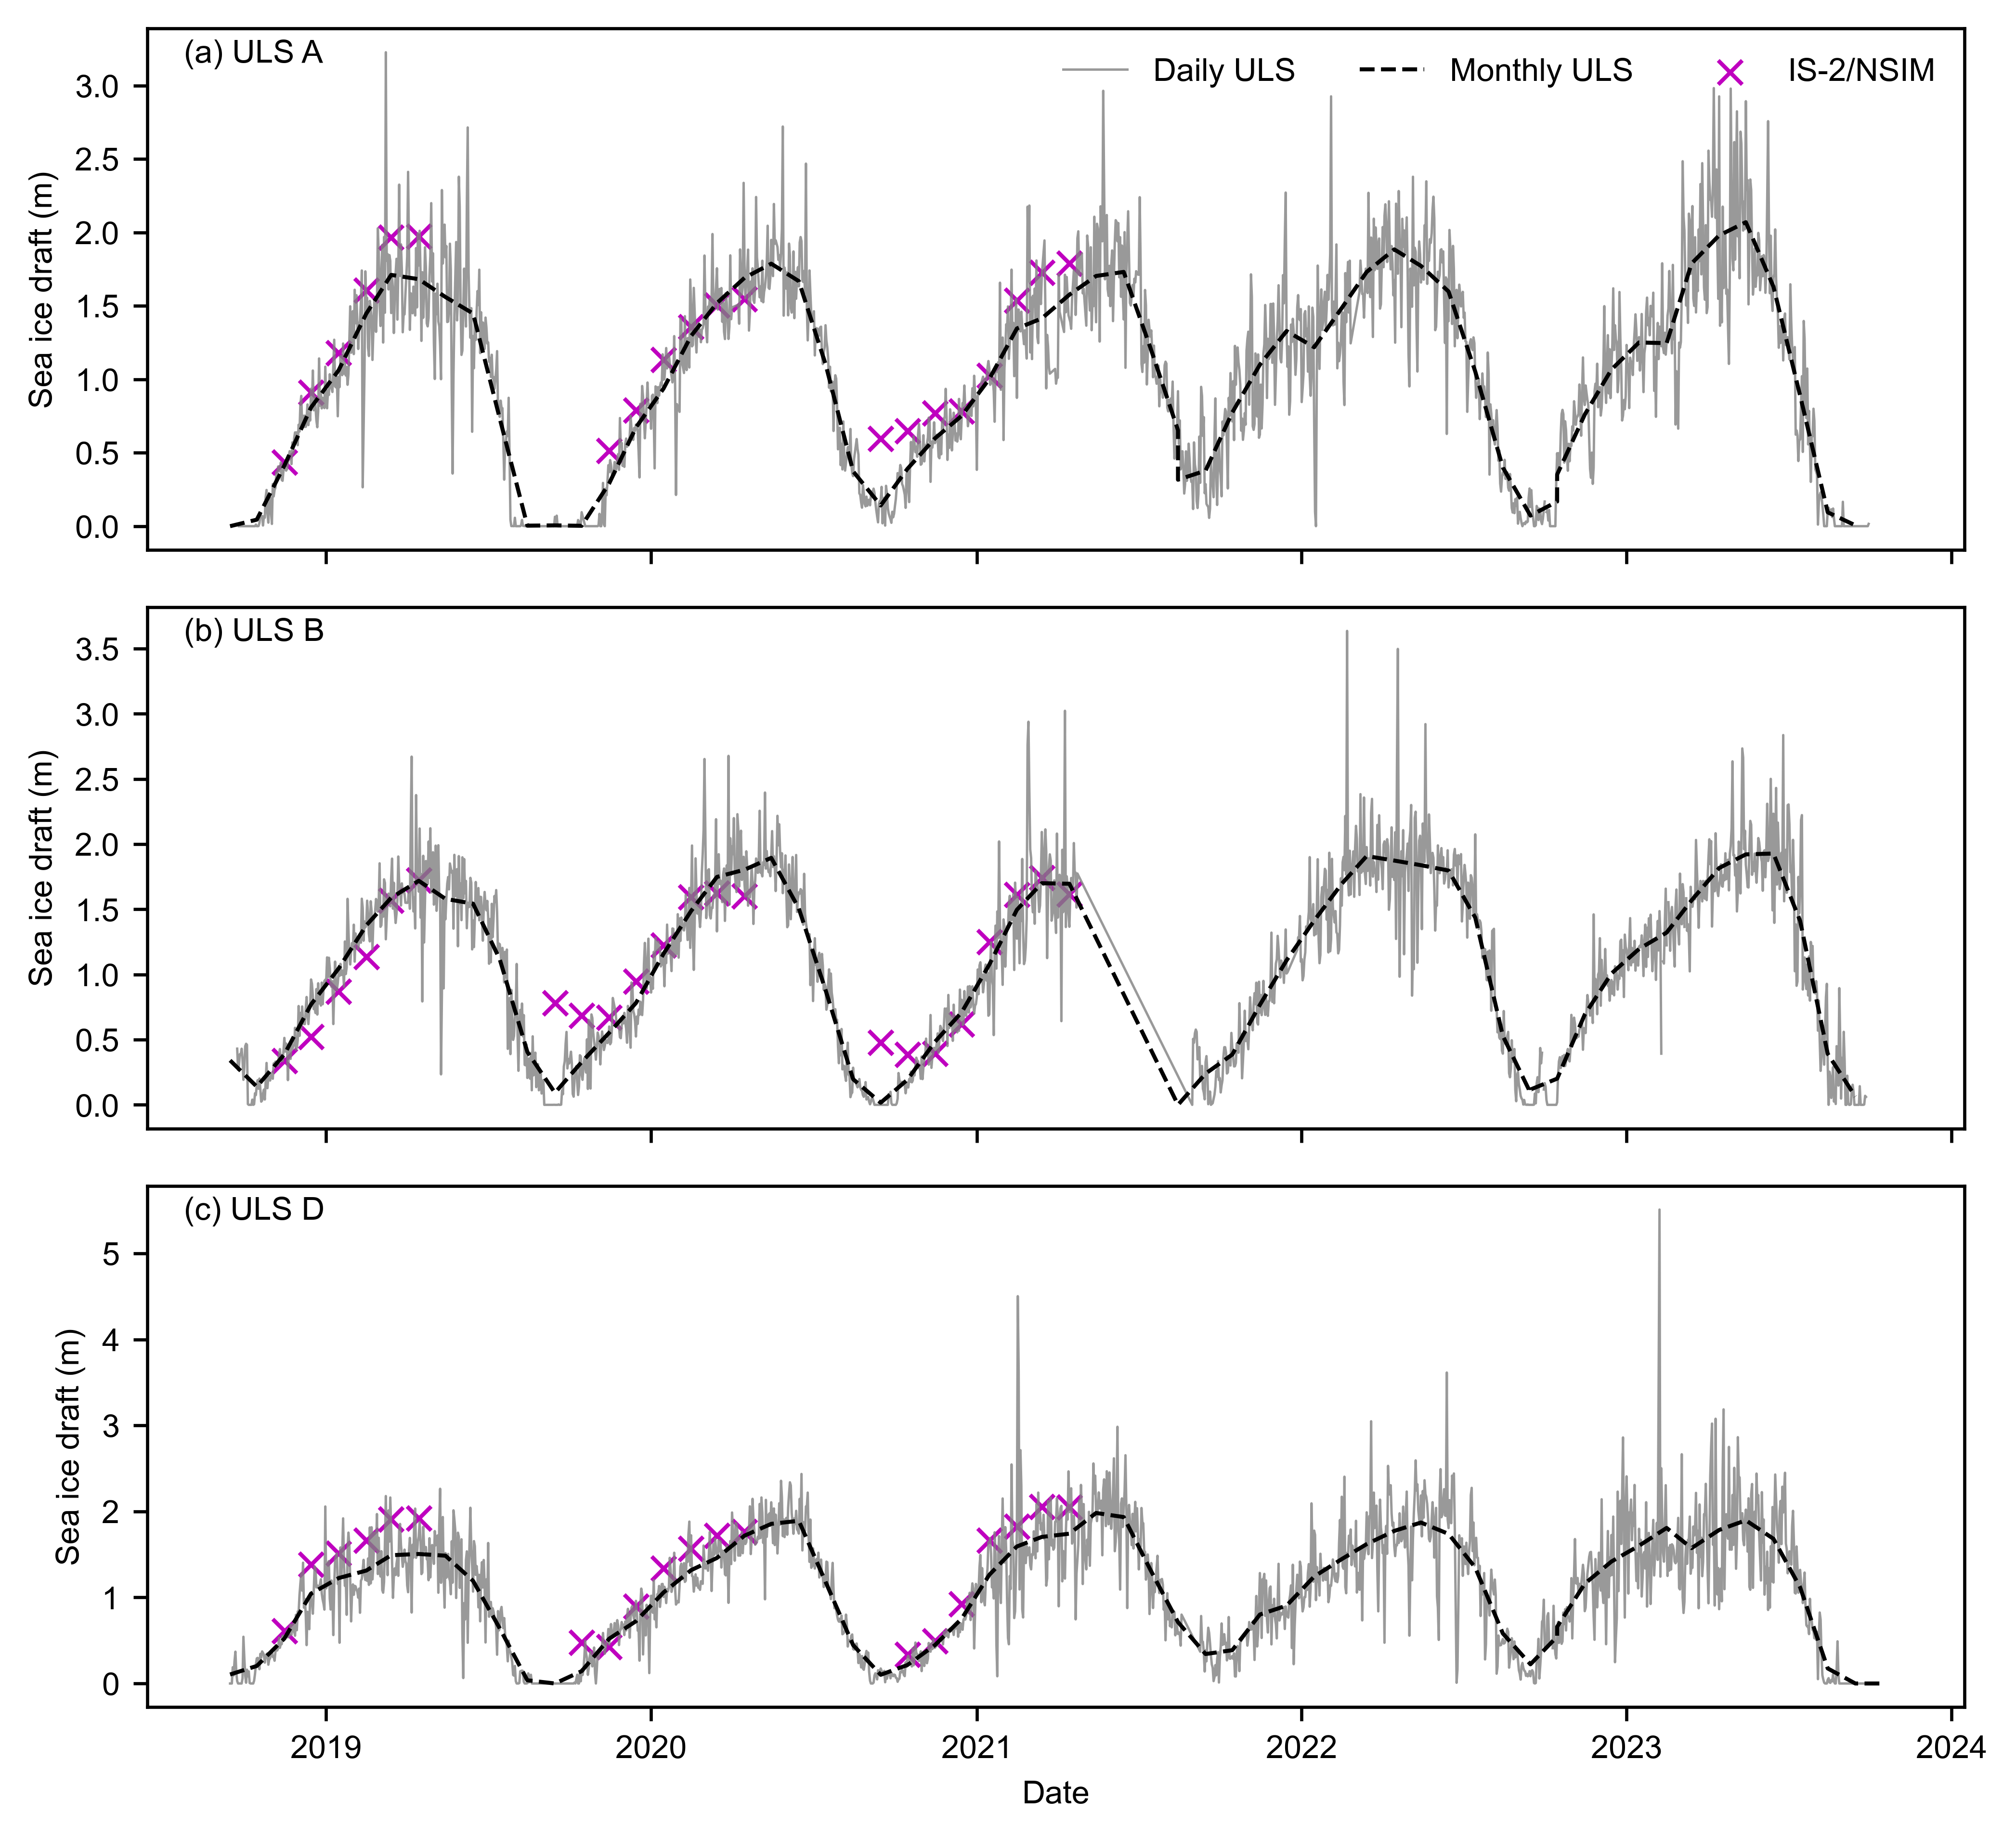

In [23]:
# Define a function to create plots for a given option
def create_comb_plot_matplotlib(option):
    print(option)
    # Set the figure size to 6.8 inches wide and adjust the height accordingly
    fig, axes = plt.subplots(3, 1, figsize=(6.8, 7), sharex=True)


    # Plot for ULS A
    axes[0].plot(uls_mean_daily_draft_a.index, uls_mean_daily_draft_a, label="Daily ULS", color='gray', linewidth=0.6, alpha=0.8)
    axes[0].plot(uls_mean_monthly_draft_a.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_a, label="Monthly ULS", linestyle='--', color='k')
    axes[0].scatter(IS2_date_range, monthly_IS2_at_ULS_a_options[option], label=option, color='m', marker='x')
    #axes[0].scatter(IS2_date_range, uls_mean_monthly_draft_a_IS2_period, label=option, color='m', marker='x')
    
    axes[0].annotate('(a) ULS A', xy=(0.02, 0.98), xycoords='axes fraction', verticalalignment='top')
    axes[0].set_ylabel('Sea ice draft (m)')
    axes[0].legend(loc='upper right', frameon=False, ncols=3)

    # Plot for ULS B
    axes[1].plot(uls_mean_daily_draft_b.index, uls_mean_daily_draft_b, label="Daily ULS", color='gray', linewidth=0.6, alpha=0.8)
    axes[1].plot(uls_mean_monthly_draft_b.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_b, label="Monthly ULS", linestyle='--', color='k')
    axes[1].scatter(IS2_date_range, monthly_IS2_at_ULS_b_options[option], label=option, color='m', marker='x')
    #axes[1].scatter(uls_mean_monthly_draft_b.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_b, label=option, color='b', marker='x')
    axes[1].annotate('(b) ULS B', xy=(0.02, 0.98), xycoords='axes fraction', verticalalignment='top')
    axes[1].set_ylabel('Sea ice draft (m)')

    # Plot for ULS D
    axes[2].plot(uls_mean_daily_draft_d.index, uls_mean_daily_draft_d, label="Daily ULS", color='gray', linewidth=0.6, alpha=0.8)
    axes[2].plot(uls_mean_monthly_draft_d.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_d, label="Monthly ULS", linestyle='--', color='k')
    #axes[2].scatter(IS2_date_range, uls_mean_monthly_draft_d_IS2_period , label=option, color='m', marker='x')
    axes[2].scatter(IS2_date_range, monthly_IS2_at_ULS_d_options[option] , label=option, color='m', marker='x')
    axes[2].annotate('(c) ULS D', xy=(0.02, 0.98), xycoords='axes fraction', verticalalignment='top')
    axes[2].set_ylabel('Sea ice draft (m)')
    axes[2].set_xlabel('Date')

    plt.subplots_adjust(left=0.065, right=0.99, top=0.95, bottom=0.12, hspace=0.11)  # Adjust these values to reduce whitespace

    plt.show()

# Example usage
create_comb_plot_matplotlib('IS-2/NSIM')

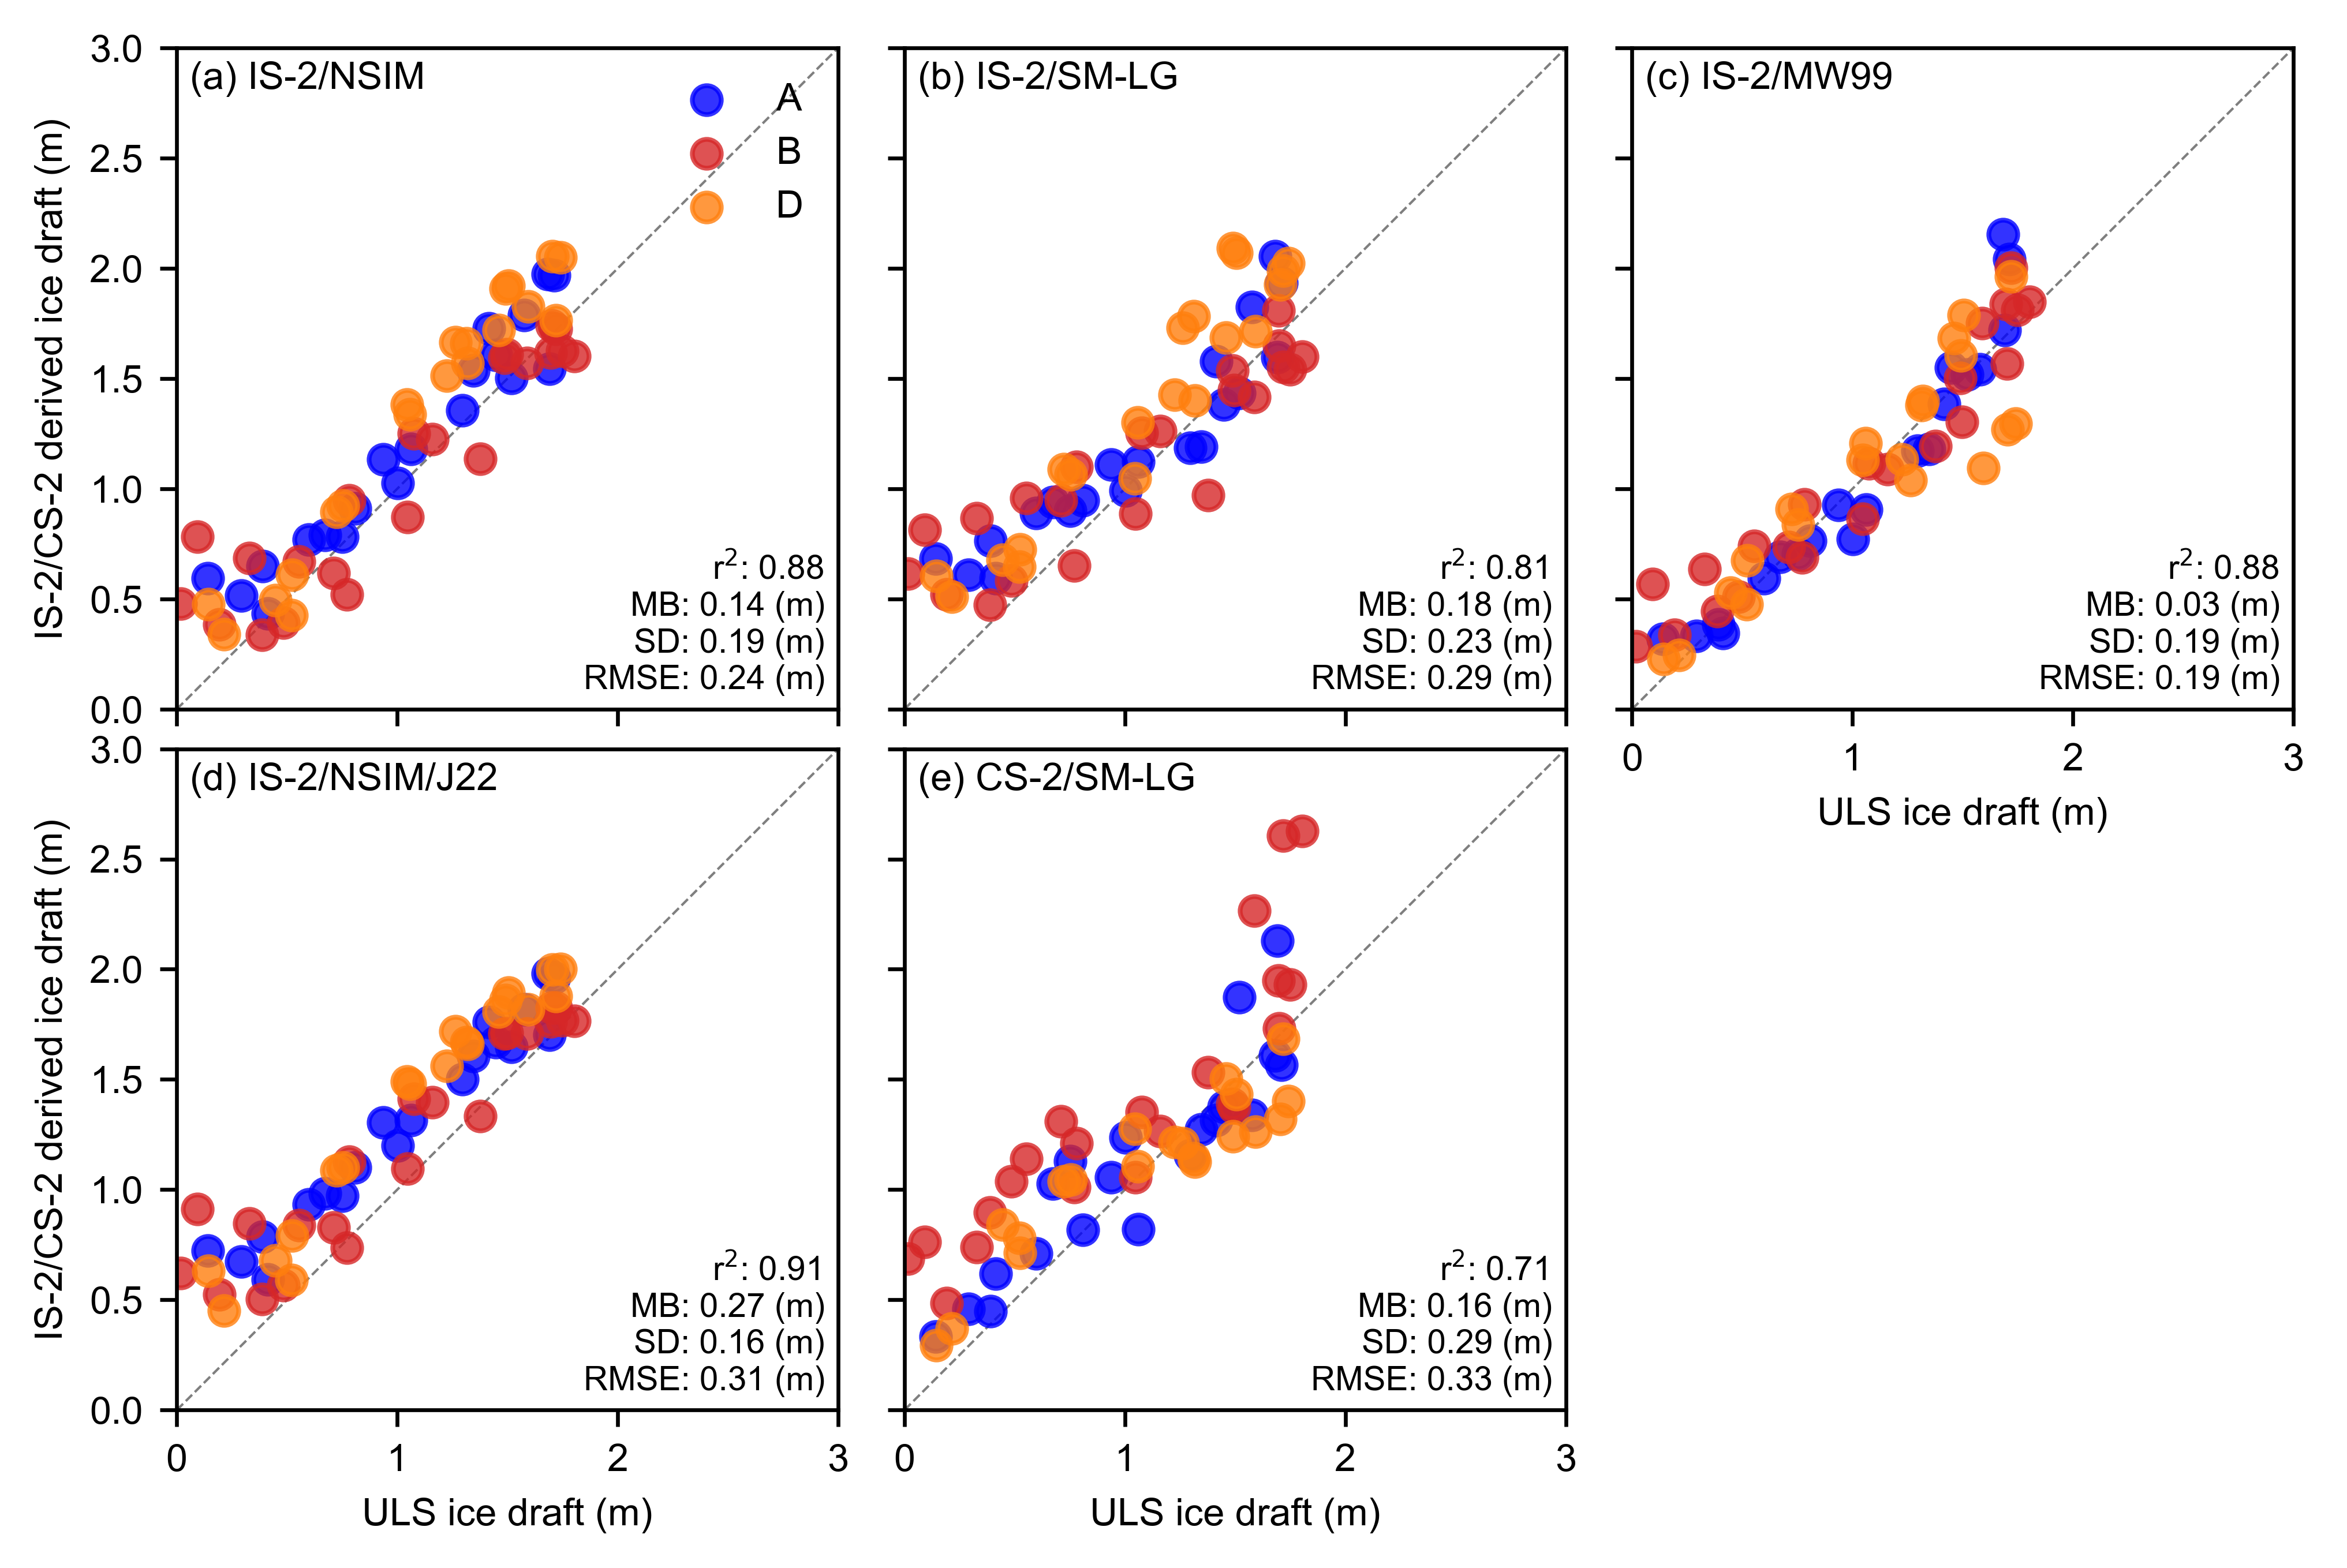

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(6.8, 6.8*0.65), gridspec_kw={'hspace': 0.06, 'wspace': 0.04})  # Adjust hspace and wspace for less whitespace
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']  # Panel labels

# Leave the third subplot on the top row empty
axes[5].axis('off')

for i, option in enumerate(options.keys()):
    ax = axes[i]
    #ax = axes[i if i < 2 else i + 1]  # Skip the third subplot on the top row
    ax.scatter(uls_mean_monthly_draft_a_IS2_period, monthly_IS2_at_ULS_a_options[option], color='b', alpha=0.8, label='A')
    ax.scatter(uls_mean_monthly_draft_b_IS2_period, monthly_IS2_at_ULS_b_options[option], color='tab:red', alpha=0.8,label='B')
    ax.scatter(uls_mean_monthly_draft_d_IS2_period, monthly_IS2_at_ULS_d_options[option], color='tab:orange', alpha=0.8,label='D')

    # Retrieve validation results for the current option
    r_str_a = validation_results[option]['r_str_a']
    mb_str_a = validation_results[option]['mb_str_a']
    sd_str_a = validation_results[option]['sd_str_a']
    r_str_b = validation_results[option]['r_str_b']
    mb_str_b = validation_results[option]['mb_str_b']
    sd_str_b = validation_results[option]['sd_str_b']
    r_str_d = validation_results[option]['r_str_d']
    mb_str_d = validation_results[option]['mb_str_d']
    sd_str_d = validation_results[option]['sd_str_d']
    r_str_all = validation_results[option]['r_str_all']
    mb_str_all = validation_results[option]['mb_str_all']
    sd_str_all = validation_results[option]['sd_str_all']

    # Calculate RMSE for each ULS
    rmse_a = np.sqrt(np.nanmean((np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period))**2))
    rmse_b = np.sqrt(np.nanmean((np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period))**2))
    rmse_d = np.sqrt(np.nanmean((np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period))**2))
    rmse_all = np.sqrt(np.nanmean((np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period))**2))

    # Annotate the plot with RMSE, mean bias, and standard deviation
    #ax.annotate(f"A  r$^2$: {r_str_a}  MB: {mb_str_a} (m) SD: {sd_str_a} (m)  RMSE: {rmse_a:.02f} (m)", color='b', xy=(0.02, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
    #ax.annotate(f"B  r$^2$: {r_str_b}  MB: {mb_str_b} (m) SD: {sd_str_b} (m)  RMSE: {rmse_b:.02f} (m)", color='tab:red', xy=(0.02, 0.92), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
    #ax.annotate(f"D  r$^2$: {r_str_d}  MB: {mb_str_d} (m) SD: {sd_str_d} (m)  RMSE: {rmse_d:.02f} (m)", color='tab:orange', xy=(0.02, 0.86), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
    ax.annotate(f"r$^2$: {r_str_all} \nMB: {mb_str_all} (m)\nSD: {sd_str_all} (m)\nRMSE: {rmse_all:.02f} (m)", color='k', xy=(0.98, 0.02), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom', fontsize=7)

    # Combine panel label with option label
    ax.annotate(f"{panel_labels[i]} "+option, xy=(0.02, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

    # Set x and y labels only for the leftmost and bottom plots
    if (i==0):
        ax.legend(frameon=False, loc="upper right")
    if (i == 0)|(i==3):
        ax.set_ylabel('IS-2/CS-2 derived ice draft (m)')
    else:
        ax.set_yticklabels('')
    if i >= 2:
        ax.set_xlabel('ULS ice draft (m)')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    #ax.legend()

#plt.tight_layout()
plt.subplots_adjust(left=0.065, right=0.98, top=0.98, bottom=0.09)  # Adjust these values to reduce whitespace

plt.savefig('./figs/BGEP_winter_scatter_res'+str(comp_res)+'_nn_'+start_date+end_date+int_str+'_inccs2.pdf', dpi=300)
plt.show()
